# Which types of countries in the world consume the most rice?

It seems straightforward but there are a few factors that may influence this:
- How easy is it to grow rice there? Places where rice grows easily are more likely to have been cultivating it for longer, creating a culture, cuisine, and agricultural practice around the staple
- How wealthy are individuals in the country? Rice is typically easier to store, distribute, and prepare for low income individuals meaning some countries may consume more rice despite not being a traditional crop
- exposure to rice: South America doesn't grow much of rice but it's a key part of the cuisine because the spanish brought it over during colonialization.

### Conclusion
- these observed variables aren't enough to say with much confidence- for each general observation there are some huge caveats which undermine the value of the finding
- wealth is the biggest predictor of rice consumption
- Individuals in Asian countries get ~12% more of their calories from rice than the rest of the world, after accounting for income and rice consumption
- the relationship between rice consumption and rice production is strong and exponential

### Sources
http://ricestat.irri.org:8080/wrsv3/entrypoint.htm<br>
https://en.wikipedia.org/wiki/List_of_countries_by_food_energy_intake<br>
https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita<br>
http://worldpopulationreview.com/countries/hdi-by-country/<br>
https://www.cia.gov/library/publications/the-world-factbook/rankorder/2172rank.html<br>
http://ricestat.irri.org:8080/wrsv3/entrypoint.htm<br>
https://www.nationmaster.com/country-info/stats/Agriculture/Grains/Wheat/Consumption

In [1]:
from hdx.location.country import Country
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp

# Summary

## import and clean country names

In [2]:
base_path = '/Users/rob/Downloads/Rice Consumption Per Capita.xlsx - {}'
rice_consumption_df = pd.read_csv(base_path.format('percapita_rice_consumption.csv'))
overall_consumption_df = pd.read_csv(base_path.format('overall_kcal_consumption.csv'), thousands=',')
gdp_per_capita_df = pd.read_csv(base_path.format('gdp_per_capita_ppp.csv'), thousands=',')
hdi_df = pd.read_csv(base_path.format('hdi.csv'), thousands=',')
gini_df = pd.read_csv(base_path.format('gini.csv'))
production_df = pd.read_csv(base_path.format('rice_production.csv'))
region_df = pd.read_csv(base_path.format('region.csv'))

In [3]:
rice_consumption_df['iso'] = rice_consumption_df['Country'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])
overall_consumption_df['iso'] = overall_consumption_df['Country'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])
gdp_per_capita_df['iso'] = gdp_per_capita_df['Country/Territory'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])
hdi_df['iso'] = hdi_df['Country'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])
gini_df['iso'] = gini_df['country'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])
production_df['iso'] = production_df['Country'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])
region_df['iso'] = region_df['Country'].apply(lambda x: Country.get_iso3_country_code_fuzzy(x)[0])

In [4]:
rice_consumption_df.name = 'rice_consumption_df'
overall_consumption_df.name = 'overall_consumption_df'
gdp_per_capita_df.name = 'gdp_per_capita_df'
hdi_df.name = 'hdi_df'
gini_df.name = 'gini_df'
production_df.name = 'production_df'
region_df.name = 'region_df'

## validate uniqueness and spot check

In [5]:
df_list = [rice_consumption_df, overall_consumption_df, gdp_per_capita_df, hdi_df, gini_df, production_df, region_df]

In [6]:
'''
it looks like just ndl antillies? easy fix
'''
for df in df_list:
    print('======== {} ======='.format(df.name))
    print(df['iso'].nunique(), len(df))

======== rice_consumption_df =======
175 176
======== overall_consumption_df =======
174 175
======== gdp_per_capita_df =======
190 193
======== hdi_df =======
184 184
======== gini_df =======
155 157
======== production_df =======
175 176
======== region_df =======
245 248


In [7]:
'''
it looks like just ndl antillies? easy fix
'''
for df in df_list:
    print('======== {} ======='.format(df.name))
    print(df['iso'].value_counts().nlargest(5))

======== rice_consumption_df =======
NLD    2
MRT    1
PRK    1
TJK    1
GRD    1
Name: iso, dtype: int64
======== overall_consumption_df =======
NLD    2
KWT    1
GRD    1
MLI    1
IDN    1
Name: iso, dtype: int64
======== gdp_per_capita_df =======
KWT    1
CHE    1
NAM    1
MLI    1
IDN    1
Name: iso, dtype: int64
======== hdi_df =======
KWT    1
NZL    1
BHS    1
SYC    1
BFA    1
Name: iso, dtype: int64
======== gini_df =======
IRL    1
TJK    1
ROU    1
NAM    1
MLI    1
Name: iso, dtype: int64
======== production_df =======
NLD    2
IRL    1
MNG    1
GAB    1
COL    1
Name: iso, dtype: int64
======== region_df =======
FRA    2
NZL    2
NLD    2
PAK    1
ARG    1
Name: iso, dtype: int64


In [8]:
rice_consumption_df.loc[rice_consumption_df['Country'] == 'NETHERLANDS ANTILLES', 'iso'] = 'NLD-A'
overall_consumption_df.loc[overall_consumption_df['Country'] == 'Netherlands Antilles', 'iso'] = 'NLD-A'
production_df.loc[production_df['Country'] == 'NETHERLANDS ANTILLES', 'iso'] = 'NLD-A'
region_df.loc[region_df['Country'] == 'Netherlands Antilles', 'iso'] = 'NLD-A'

region_df = region_df[region_df.Country.isin(['Aland Islands', 'France, Metropolitan'])==False]

In [9]:
df = pd.concat([
    rice_consumption_df[rice_consumption_df.iso.notnull()].set_index('iso')['Value'].rename('daily_rice_consumption')
    ,overall_consumption_df[overall_consumption_df.iso.notnull()].set_index('iso')['kilocalories'].rename('daily_energy_consumption')
    ,gdp_per_capita_df[gdp_per_capita_df.iso.notnull()].set_index('iso')['gdp_per_capita']
    ,hdi_df[hdi_df.iso.notnull()].set_index('iso')['Human Development Index'].rename('hdi')
    ,hdi_df[hdi_df.iso.notnull()].set_index('iso')['Population 2019'].rename('population')
    ,gini_df[gini_df.iso.notnull()].set_index('iso')['gini']
    ,production_df[production_df.iso.notnull()].set_index('iso')['Value'].rename('production_k_tonnes')
    ,region_df[region_df.iso.notnull()].set_index('iso')['Region'].rename('region')
], axis=1, sort=False)

In [10]:
df['rice_ratio'] = df['daily_rice_consumption'] / df['daily_energy_consumption']

#making this a column because plotting log scales with seaborn is spotty
df['log_production'] = df['production_k_tonnes'].apply(np.log)

## Analysis
What are the biggest predictors of rice consumption? 
- wealth?
- region?
- rice production potential

heteroskedasticity abounds but let's try to suss this out

### relaionship between rice consumptions and measures of wealth

HDI appears to be a better predictor than gdp per capita but our measure of income inequality shows no correlation at all. 

Rice is generally easier to store, distribute and prepare than other staples like wheat or corn. This _should_ bias the consuption toward countries with greater prevalence of individual poverty. HDI is a better measure of this than gdp per capita.

I'm kind of surprised there's not more of a relationship between gini and hdi? save for later

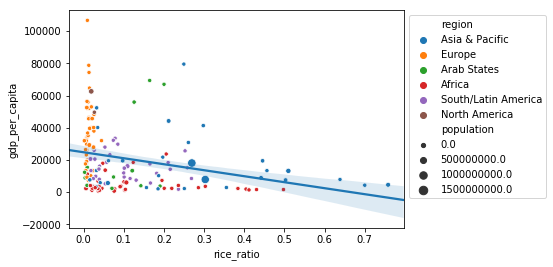

In [11]:
ax = sns.scatterplot(data=df, x='rice_ratio', y='gdp_per_capita', hue='region', size='population')
sns.regplot(data=df, x='rice_ratio', y='gdp_per_capita', scatter=False, ax=ax)
ax.legend(bbox_to_anchor=[1.0,1.0])

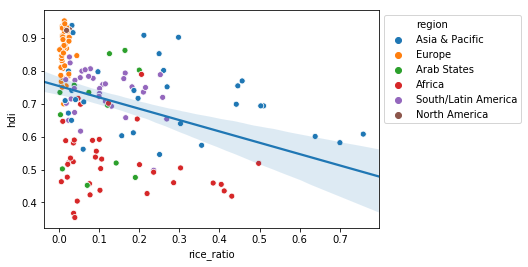

In [12]:
ax = sns.scatterplot(data=df, x='rice_ratio', y='hdi', hue='region')
sns.regplot(data=df, x='rice_ratio', y='hdi', scatter=False, ax=ax)
ax.legend(bbox_to_anchor=[1.0,1.0])

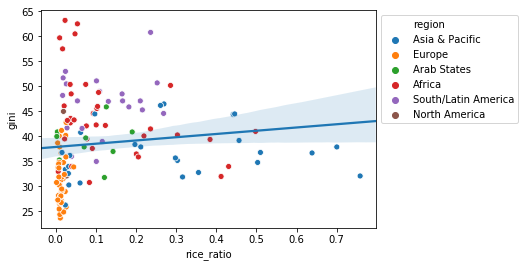

In [13]:
ax = sns.scatterplot(data=df, x='rice_ratio', y='gini', hue='region')
sns.regplot(data=df, x='rice_ratio', y='gini', scatter=False, ax=ax)
ax.legend(bbox_to_anchor=[1.0,1.0])

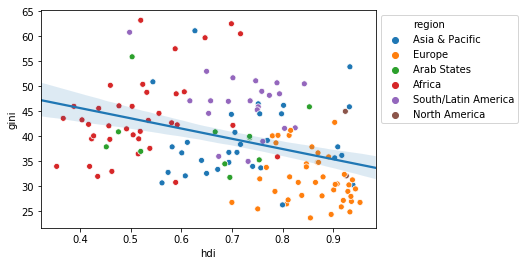

In [14]:
ax = sns.scatterplot(data=df, x='hdi', y='gini', hue='region')
sns.regplot(data=df, x='hdi', y='gini', scatter=False, ax=ax)
ax.legend(bbox_to_anchor=[1.0,1.0])

### Rice production

there is a slight relationship between hdi (our proxy for individuals' wealth) and rice production

there is a strong relationship between rice production and rice consumption

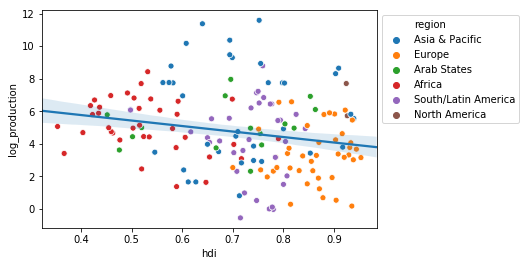

In [15]:
ax = sns.scatterplot(data=df, x='hdi', y='log_production', hue='region')
sns.regplot(data=df, x='hdi', y='log_production', scatter=False, ax=ax)
ax.legend(bbox_to_anchor=[1.0,1.0])

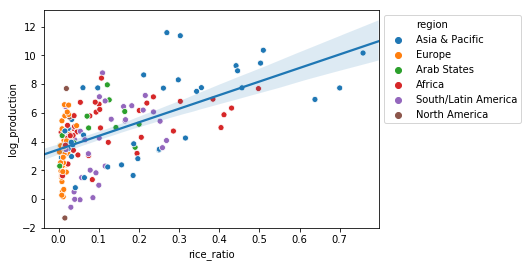

In [16]:
ax = sns.scatterplot(data=df, x='rice_ratio', y='log_production', hue='region')
sns.regplot(data=df, x='rice_ratio', y='log_production', scatter=False, ax=ax)
ax.legend(bbox_to_anchor=[1.0,1.0])

### region
Maybe income is just correlated with region and certain regions eat more rice or less rice?

This is tough because region is categorical 

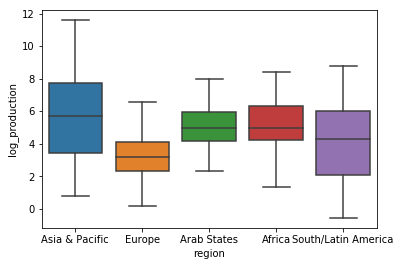

In [17]:
sns.boxplot(data=df[df.region!='North America'], x='region', y='log_production')

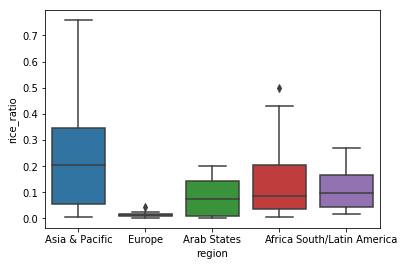

In [18]:
sns.boxplot(data=df[df.region!='North America'], x='region', y='rice_ratio')

In [19]:
import statsmodels.formula.api as smf

In [20]:
res = smf.ols(formula='rice_ratio ~ C(region) + log_production + hdi', data=df).fit()

In [21]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rice_ratio   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     20.13
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           7.01e-19
Time:                        23:10:24   Log-Likelihood:                 131.02
No. Observations:                 158   AIC:                            -246.0
Df Residuals:                     150   BIC:                            -221.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1446      0.058      2.482      0.014       0.029       0.260
C(region)[T.Arab States]            -0.0083      0.038     -0.220      0.826      -0.083       0.067
C(region)[T.Asia & Pacific]          0.1272      0.032      3.920      0.000       0.063       0.191
C(region)[T.Europe]                  0.0095      0.041      0.232      0.817      -0.071       0.090
C(region)[T.North America]          -0.0549      0.088     -0.625      0.533      -0.228       0.119
C(region)[T.South/Latin America]     0.0503      0.033      1.520      0.131      -0.015       0.116
log_production                       0.0269      0.004      6.642      0.000       0.019       0.035
hdi                                 -0.2669      0.096     -2.787      0.006      -0.456      -0.078
==============================================================================
Omnibus:                       25.756   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.613
Skew:                           0.869   Prob(JB):                     4.12e-09
Kurtosis:                       4.687   Cond. No.                         79.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
real_pred_df = pd.concat([
    df['rice_ratio'].rename('actual')
    ,res.fittedvalues.copy().rename('predicted')
], axis=1, sort=False)\
.assign(residuals= lambda _df: _df.apply(lambda row: row['actual'] - row['predicted'], axis=1))

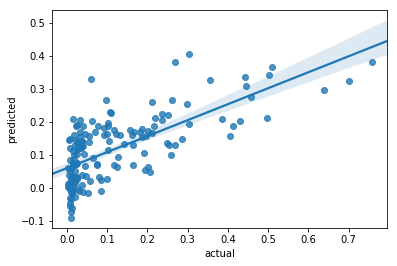

In [23]:
#egads! correlated error!
sns.regplot(
    data=real_pred_df.dropna(how='any')
    ,x='actual'
    ,y='predicted'
)

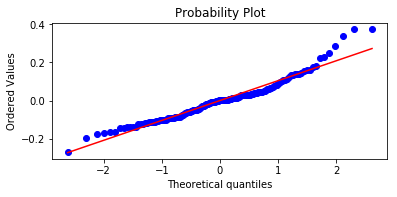

In [24]:
# seems relatively linear?
fig, ax = plt.subplots(figsize=(6,2.5))

_ = sp.stats.probplot(real_pred_df.dropna()['residuals'], fit=True, plot=ax)

## Alternative Hypotheses
- countries in cold climates don't eat rice
- countries with a strong history with another staple don't eat rice

### countries in cold climates don't eat rice
this is tough since countries in colder climates tend to also be wealthier and similar in terms of race and region. one exception is Mongolia which is super cold and right next to some of the biggest rice consuming cultures in the world. They eat basically no rice :/ other central asian countries are cold, culturally somewhat similar to other rice eating countries and eat very little rice. Pakistan is another interesting example

In [25]:
df.loc['MNG']

daily_rice_consumption                  72
daily_energy_consumption              2240
gdp_per_capita                       13447
hdi                                  0.741
population                     3.22517e+06
gini                                    34
production_k_tonnes                  19.43
region                      Asia & Pacific
rice_ratio                       0.0321429
log_production                     2.96682
Name: MNG, dtype: object

### countries with a strong history with another staple don't eat rice

I don't want to try to find wheat or corn data but this makes some since since European and North American countries cultivate a bunch of wheat and have their diets traditionally based on it.

Wheat grows best in places that alternate dry and wet seasons. This means it grows best in North America, Europe, Northern Africa (especially Ethiopia), the northern part of the Indian subcontient and northern China.